# **CNN Milestone 1: Classifying CIFAR10**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**

* **CIFAR**: Canadian Institute For Advanced Research
    * CIFAR10
        * has 10 categories
        * 50000 RGB (3 channel images) each of 32x32 pixels

------------

### **Imports and setting up device**

In [2]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# import torchvision and transformations libraries
import torchvision as tv
import torchvision.transforms as T

In [3]:
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

### **Import data and visualize the images, data and labels**

In [4]:
# Import a dataset
# download the CIFAR10 dataset
cdata=tv.datasets.CIFAR10(root='cifar10',download=True)
print(cdata)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train


In [5]:
# check out the shape of the dataset
print(cdata.data.shape) 

# the unique categories
print(cdata.classes)
print(np.unique(cdata.targets))

# .targets is a list of targets converted into integers
print(len(cdata.targets))


(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[0 1 2 3 4 5 6 7 8 9]
50000


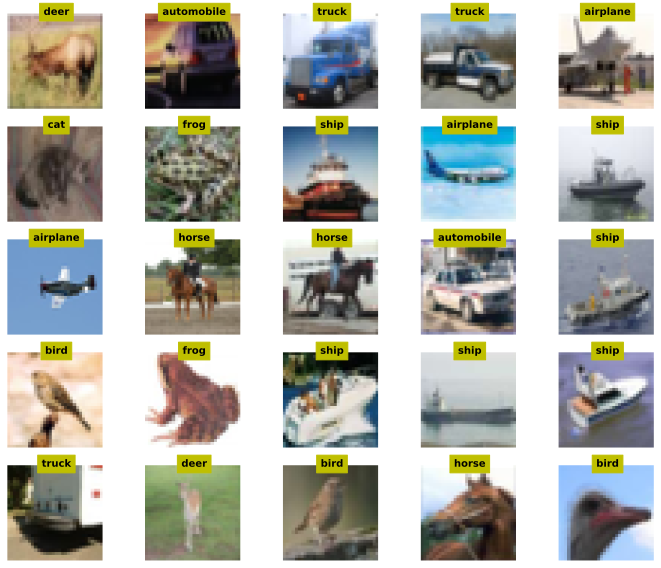

In [6]:
# inspect a few random images
fig,axs=plt.subplots(5,5,figsize=(10,8))
for ax in axs.flatten():
    # select a random picture
    randidx=np.random.choice(len(cdata.targets))

    # extract that image
    pic=cdata.data[randidx,:,:,:]
    # and its label
    label = cdata.classes[cdata.targets[randidx]]

    # and show!
    ax.imshow(pic)
    ax.text(16,0,label,ha='center',fontweight='bold',color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

____________

### **Data pre-processing**

In [7]:
# categories (classes)
categories=cdata.classes

# labels
labels=cdata.targets
print(len(labels))

### labels is a list


50000


In [8]:
### converting labels and data into tensors

### labels
labels=tr.Tensor(labels).long()
labels=labels.reshape([-1,1])
print(labels.shape)

### Using transformations to convert data into tensor and normalize the images in range [0,1]
data=tr.zeros(size=(50000,cdata.data.shape[3],cdata.data.shape[1],cdata.data.shape[2]))

Ts=T.Compose([T.ToTensor()])

for i in range(data.shape[0]):
    data[i,:,:,:]=Ts(cdata.data[i,:,:,:])

print(data.shape)

torch.Size([50000, 1])
torch.Size([50000, 3, 32, 32])


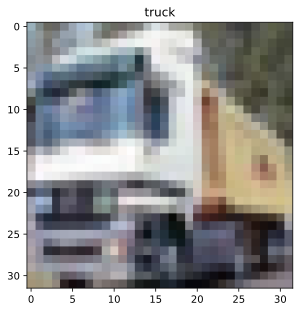

In [9]:
# visualizing one data image after transformation
plt.imshow(data[1,:,:,:].permute((1,2,0)))
plt.title(categories[int(labels[1].item())])
plt.show()

In [10]:
# creating train-dev-test sets

# step 1: use scikit-learn to split the data
train_data_total,test_data,train_labels_total,test_labels=train_test_split(data,labels,test_size=0.1)
train_data,dev_data,train_labels,dev_labels=train_test_split(train_data_total,train_labels_total,test_size=0.1)

# step 2: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
dev_data=TensorDataset(dev_data,dev_labels)
test_data= TensorDataset(test_data,test_labels)

# step 3: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader=DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# check size (should be images x channels x width x height)
print("Train Data")
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

print("Development Data")
print(dev_loader.dataset.tensors[0].shape)
print(dev_loader.dataset.tensors[1].shape)

print("Test Data")
print(test_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[1].shape)

Train Data
torch.Size([40500, 3, 32, 32])
torch.Size([40500, 1])
Development Data
torch.Size([4500, 3, 32, 32])
torch.Size([4500, 1])
Test Data
torch.Size([5000, 3, 32, 32])
torch.Size([5000, 1])


____________________

### **Model Creation**

In [11]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

In [12]:
# creating a class for the model

convOutChannels=[64,128,256]
input_channels=3
imgSize=(32,32)
kernelSize=(3,3)
strideSize=(1,1)
paddingSize=(1,1)
poolSize=(2,2)
fc_nodes=[128,64,32]
out_nodes=10

def createNet(printtoggle=False,lr=0.001):
    class Net(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            ### --- convolution layers --- ###

            # conv 1
            self.conv1=nn.Conv2d(input_channels,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.bnorm1=nn.BatchNorm2d(convOutChannels[0]) # input the number of channels in this layers

            # conv 2
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.bnorm2=nn.BatchNorm2d(convOutChannels[1]) # input the number of channels in this layers

            # conv 3
            self.conv3=nn.Conv2d(convOutChannels[1],convOutChannels[2],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.bnorm3=nn.BatchNorm2d(convOutChannels[2]) # input the number of channels in this layers


            ### --- calculating ouptut of each conv-layer for input to Linear decision layer--- ###
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])
            self.outcp3=outConvPoolSize(self.outcp2[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[2])
            self.fci=fcInput(self.outcp3[2],self.outcp3[0])


            ### --- linear decision layer --- ### 

            # fc1
            self.fc1=nn.Linear(self.fci,fc_nodes[0])
            self.fbnorm1=nn.BatchNorm1d(fc_nodes[0])

            # fc2
            self.fc2=nn.Linear(fc_nodes[0],fc_nodes[1])
            self.fbnorm2=nn.BatchNorm1d(fc_nodes[1])

            # fc3
            self.fc3=nn.Linear(fc_nodes[1],fc_nodes[2])
            self.fbnorm3=nn.BatchNorm1d(fc_nodes[2])


            ### --- output layer --- ###
            self.out=nn.Linear(fc_nodes[2],out_nodes)

            # toggle for printing out tensor sizes during forward prop
            self.print=printtoggle

        # forward propogation
        def forward(self,x):
            print(f'Input: {x.shape}') if self.print else None

            ### --- convolution - maxpool -batchnormalize - leaky_relu layers - dropout --- ###
            
            ### (1)
            x = F.leaky_relu(self.bnorm1(F.max_pool2d(self.conv1(x),2)))
            x=F.dropout2d(x,p=0.1,training=self.training)

            print(f'Layer conv1/pool1: {x.shape}') if self.print else None

            ### (2)
            x = F.leaky_relu(self.bnorm2(F.max_pool2d(self.conv2(x),2)))
            x=F.dropout2d(x,p=0.1,training=self.training)
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None

            ### (3)
            x = F.leaky_relu(self.bnorm3(F.max_pool2d(self.conv3(x),2)))
            x=F.dropout2d(x,p=0.1,training=self.training)
            print(f'Layer conv3/pool3: {x.shape}') if self.print else None

            # reshape for linear layer
            ### x.shape.numel() -->  gives total number of elements in the array/tuple
            nUnits=x.shape.numel()/x.shape[0]
            ### vectorizing
            x=x.view(-1,int(nUnits))
            print(f'Vectorize: {x.shape}') if self.print else None
            
            ### --- linear decision layer with batchnormalization & dropout --- ### 
            
            ### (1)
            x=F.leaky_relu(self.fbnorm1(self.fc1(x)))
            x=F.dropout(x,p=0.3,training=self.training)
            print(f'Layer fc1: {x.shape}') if self.print else None

            ### (2)
            x=F.leaky_relu(self.fbnorm2(self.fc2(x)))
            x=F.dropout(x,p=0.3,training=self.training)
            print(f'Layer fc2: {x.shape}') if self.print else None

            ### (3)
            x=F.leaky_relu(self.fbnorm3(self.fc3(x)))
            x=F.dropout(x,p=0.3,training=self.training)
            print(f'Layer fc3: {x.shape}') if self.print else None

            x=self.out(x)
            print(f'Output: {x.shape}') if self.print else None

            return x
    
    # create the model instance
    net=Net(printtoggle)

    # loss function
    lossfun=nn.CrossEntropyLoss()

    # optimizer
    optimizer=tr.optim.Adam(net.parameters(),lr=lr)
    
    return net,lossfun,optimizer

In [13]:
# test the model with one batch
net,lossfun,optimizer = createNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

print('\nLabel size:')
print(y.shape)
# print(y)
# print(tr.squeeze(y))

# check size of output
print('\nOutput size:')
print(yHat.shape)
# print(yHat)

# # now let's compute the loss
loss = lossfun(yHat,tr.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 3, 32, 32])
Layer conv1/pool1: torch.Size([32, 64, 16, 16])
Layer conv2/pool2: torch.Size([32, 128, 8, 8])
Layer conv3/pool3: torch.Size([32, 256, 4, 4])
Vectorize: torch.Size([32, 4096])
Layer fc1: torch.Size([32, 128])
Layer fc2: torch.Size([32, 64])
Layer fc3: torch.Size([32, 32])
Output: torch.Size([32, 10])

Label size:
torch.Size([32, 1])

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3358, grad_fn=<NllLossBackward0>)


In [14]:
# count the total number of parameters in the model
net.to(device)
summary(net,(input_channels,imgSize[0],imgSize[1]))

Input: torch.Size([2, 3, 32, 32])
Layer conv1/pool1: torch.Size([2, 64, 16, 16])
Layer conv2/pool2: torch.Size([2, 128, 8, 8])
Layer conv3/pool3: torch.Size([2, 256, 4, 4])
Vectorize: torch.Size([2, 4096])
Layer fc1: torch.Size([2, 128])
Layer fc2: torch.Size([2, 64])
Layer fc3: torch.Size([2, 32])
Output: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3          [-1, 128, 16, 16]          73,856
       BatchNorm2d-4            [-1, 128, 8, 8]             256
            Conv2d-5            [-1, 256, 8, 8]         295,168
       BatchNorm2d-6            [-1, 256, 4, 4]             512
            Linear-7                  [-1, 128]         524,416
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9           

In [15]:
# Create a function that trains the model

def trainModel(n_epochs=10):
    # create a new model
    net,lossfun,optimizer=createNet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    devLoss = tr.zeros(n_epochs)
    trainAcc = tr.zeros(n_epochs)
    devAcc = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]
        batchErr=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)
            y_lab=tr.squeeze(y)
            loss=lossfun(yHat,y_lab)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchErr.append(tr.mean((tr.argmax(yHat,axis=1)==y_lab).float()).item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)
        trainAcc[epochi]=100*np.mean(batchErr)

        # test accuracy
        X,y=next(iter(dev_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        
        y_lab=tr.squeeze(y)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)
            loss=lossfun(yHat,y_lab)

        # compare the following really long lines of code to the training accuracy lines
        devLoss[epochi]=loss.item()
        devAcc[epochi]=100*tr.mean((tr.argmax(yHat,axis=1)==y_lab).float()).item()

        print(f"{epochi+1}/{n_epochs} complete!")
    # end of epochs

    # function output
    return trainLoss,devLoss,trainAcc,devAcc,net

In [16]:
# Run the model and show the results!
trainLoss,devLoss,trainAcc,devAcc,net=trainModel()

1/10 complete!
2/10 complete!
3/10 complete!
4/10 complete!
5/10 complete!
6/10 complete!
7/10 complete!
8/10 complete!
9/10 complete!
10/10 complete!


In [17]:
X,y=next(iter(test_loader))
yHat=net(X)
test_acc=(100*tr.mean(((tr.argmax(yHat,axis=1)==tr.squeeze(y)).float())))

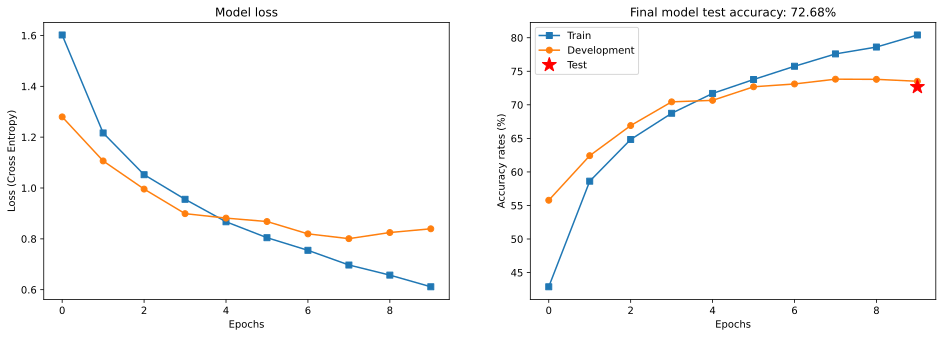

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Development')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (Cross Entropy)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Development')
ax[1].plot(9,test_acc,'r*',label="Test",markersize="15")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy rates (%)')
ax[1].set_title(f'Final model test accuracy: {test_acc:.2f}%')
ax[1].legend()

plt.show()